In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from bepsf.image import *
from bepsf.psfmodel import *
from bepsf.utils import *
from bepsf.infer import *

In [2]:
import matplotlib.pyplot as plt
import corner
import pandas as pd
from arviz import plot_trace
from jax.config import config
config.update('jax_enable_x64', True)

In [3]:
plt.rcParams['figure.dpi'] = 150

In [4]:
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils.datasets import load_star_image
from photutils.detection import DAOStarFinder

In [11]:
def find_sources(data, sort=True, plot=True, Nplot=20, norm='log'):
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)  
    #print((mean, median, std))  
    daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)  
    sources = daofind(data - median).to_pandas()
    if sort:
        sources = sources.sort_values("flux", ascending=False).reset_index(drop=True)
    if plot:
        # 1st index: row, 2nd index: col
        xcs, ycs = np.array(sources[['xcentroid', 'ycentroid']]).T
        plt.figure()
        plt.imshow(data[:,:], origin='lower', norm=norm)
        plt.plot(xcs[:20], ycs[:20], '.', marker='o', mfc='none', color='tan')
        plt.colorbar(label='count')
    return sources

def plot_individual_sources(data, sources, width=20, norm='log'):
    xcs, ycs = np.array(sources[['xcentroid', 'ycentroid']]).T
    for xc, yc in zip(xcs, ycs):
        plt.figure()
        plt.xlim(xc-0.5*width, xc+0.5*width)
        plt.ylim(yc-0.5*width, yc+0.5*width)
        plt.imshow(data, origin='lower', norm=norm)
        plt.colorbar()

In [6]:
hdul = fits.open("magO_MB116_kp_tdOpen.fits")
data_raw = hdul[0].data

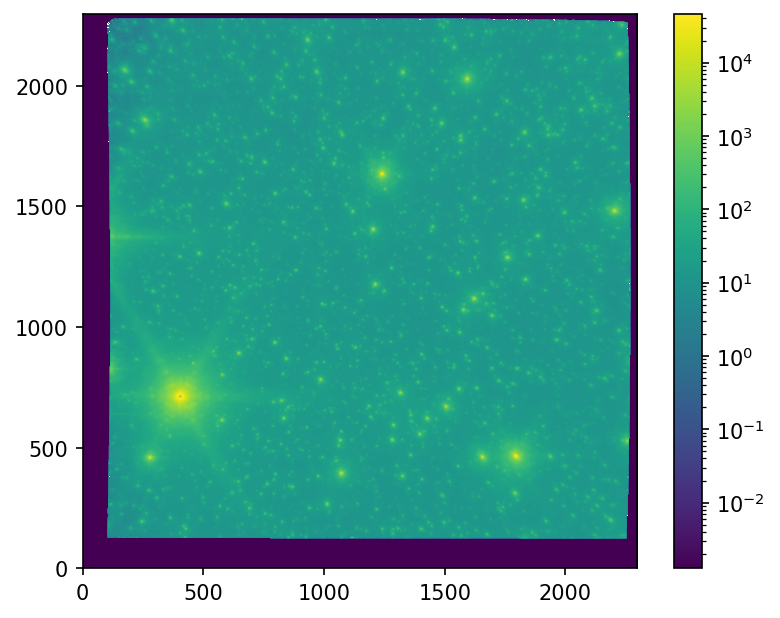

In [8]:
plt.imshow(data_raw, origin='lower', norm='log')
plt.colorbar()

In [31]:
d_cut = data_raw[1000:1500,500:1000]

/var/folders/68/h6r0kcq50914zzw8n_70l69c0000gn/T/ipykernel_13280/3224539913.py:13: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(xcs[:20], ycs[:20], '.', marker='o', mfc='none', color='tan')


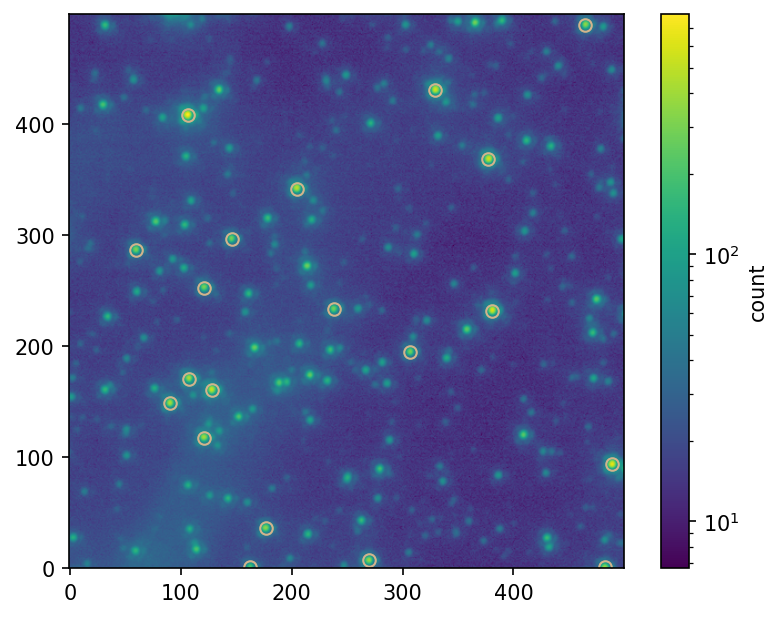

In [32]:
s_cut = find_sources(d_cut)

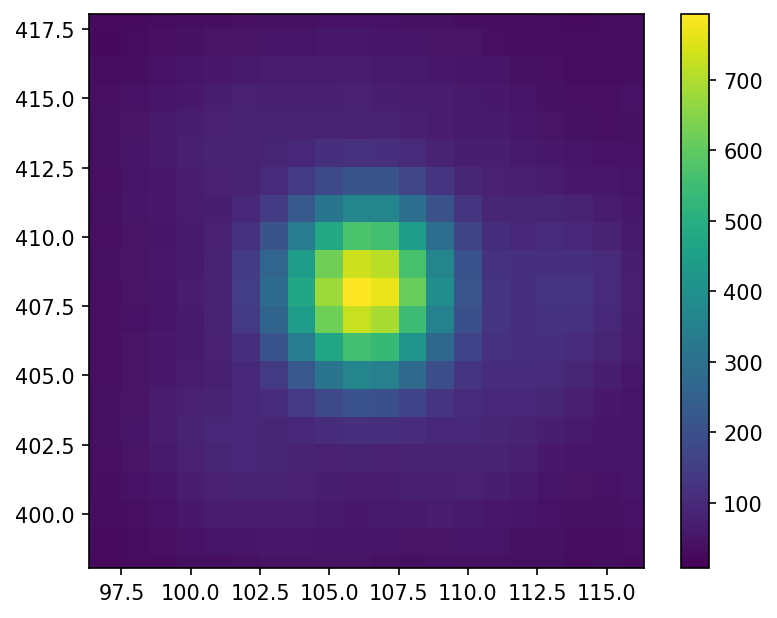

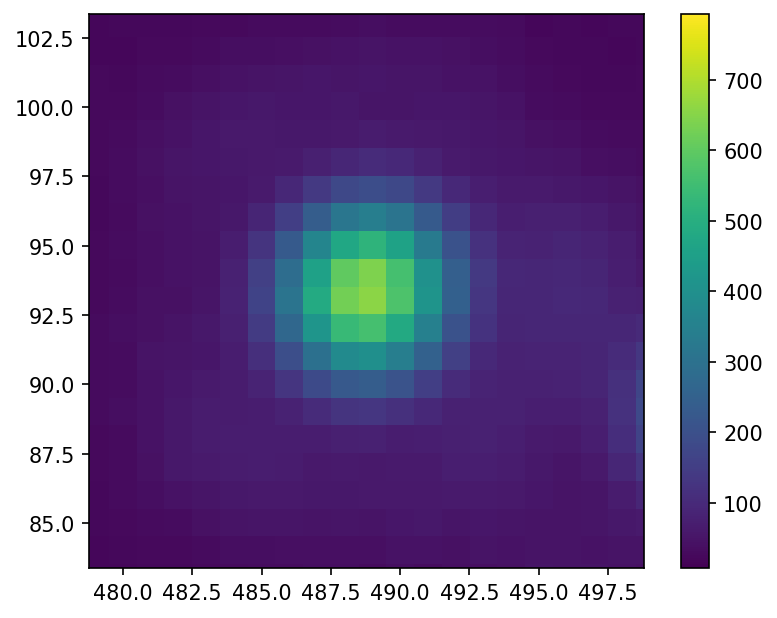

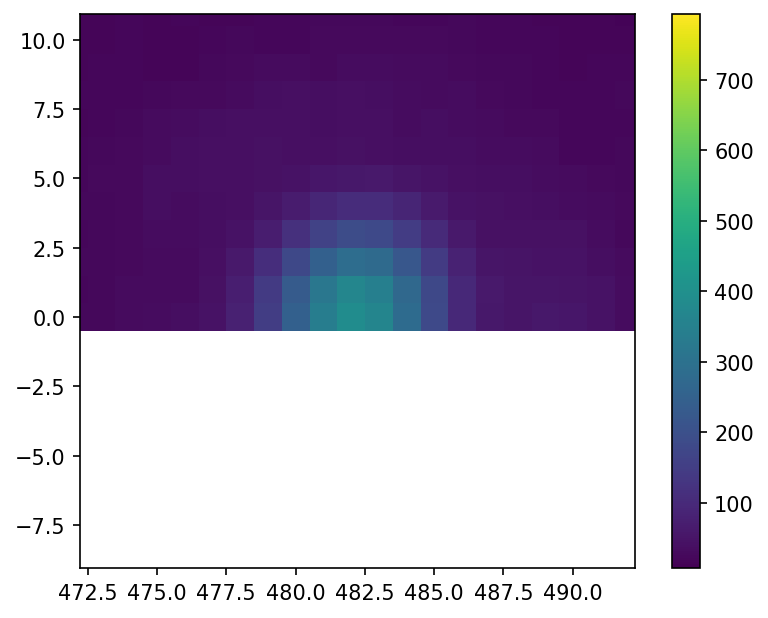

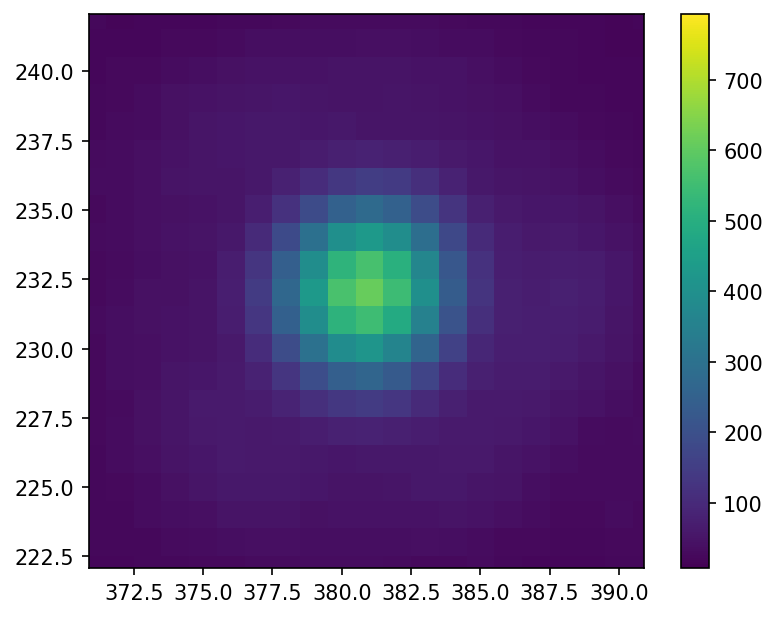

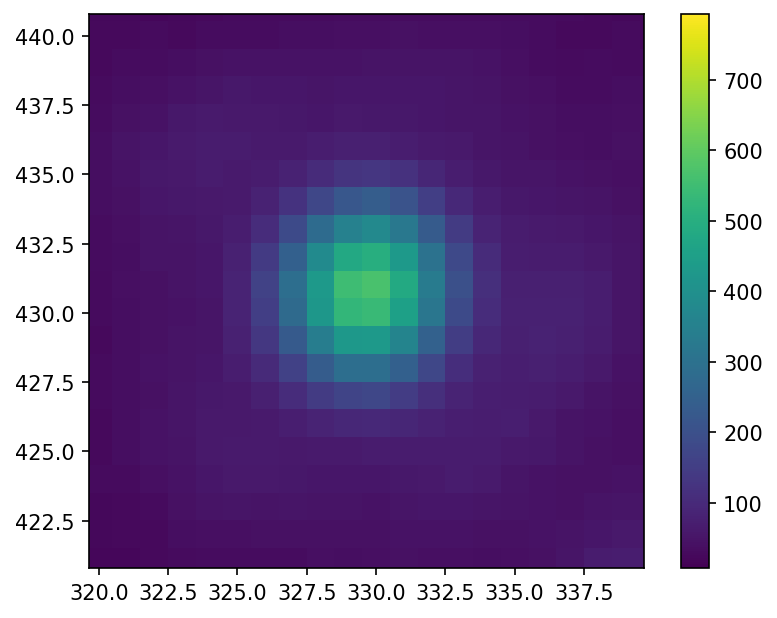

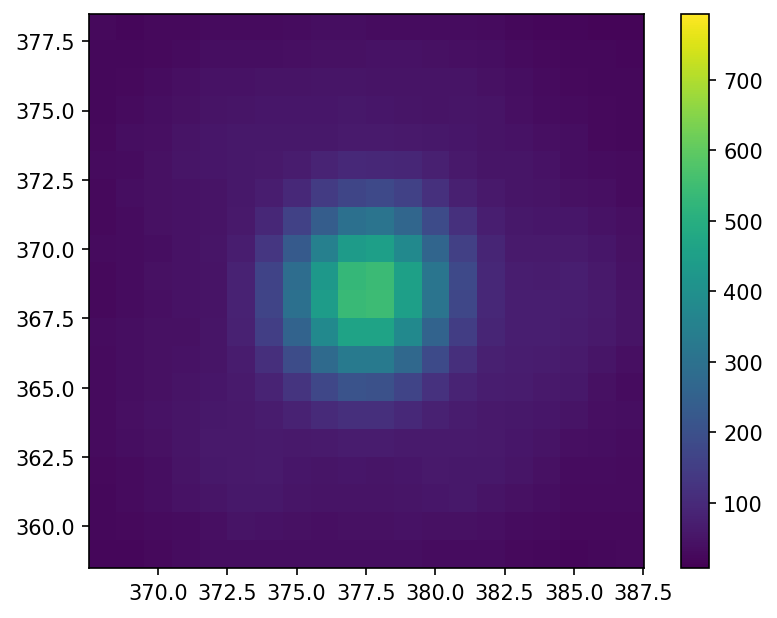

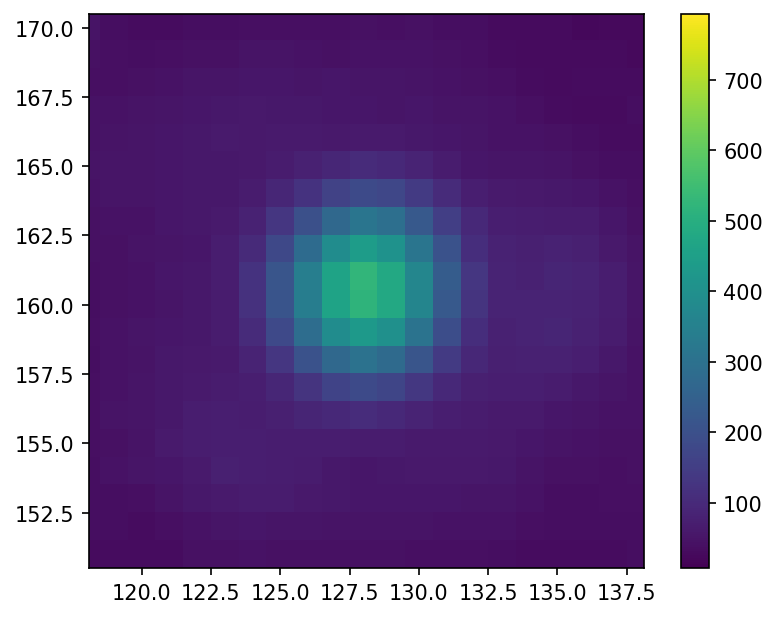

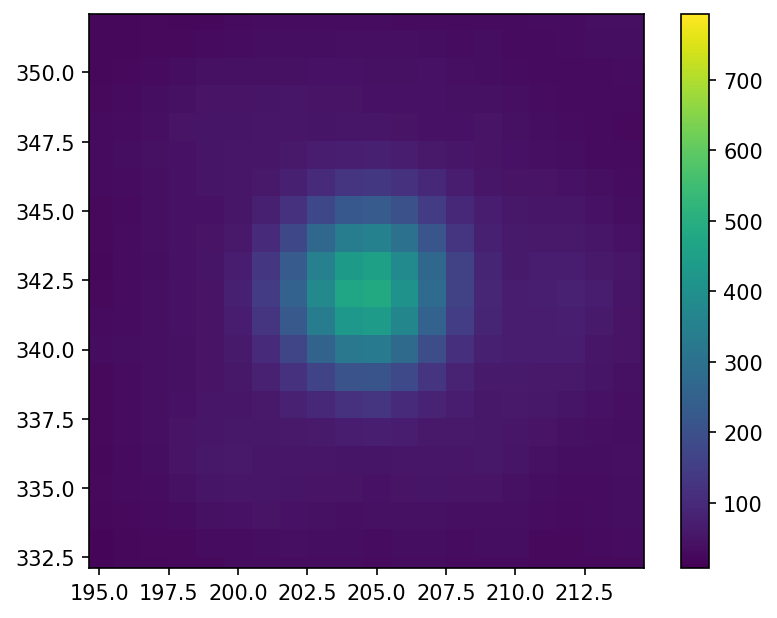

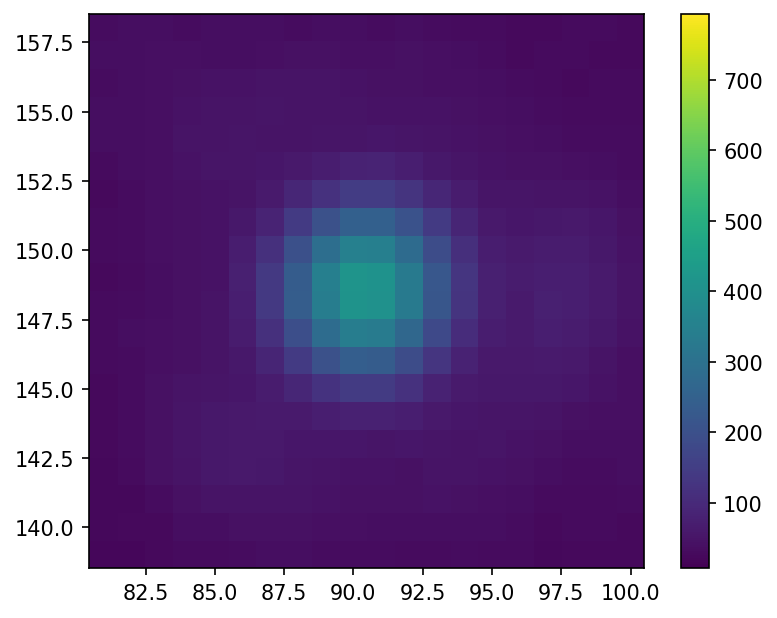

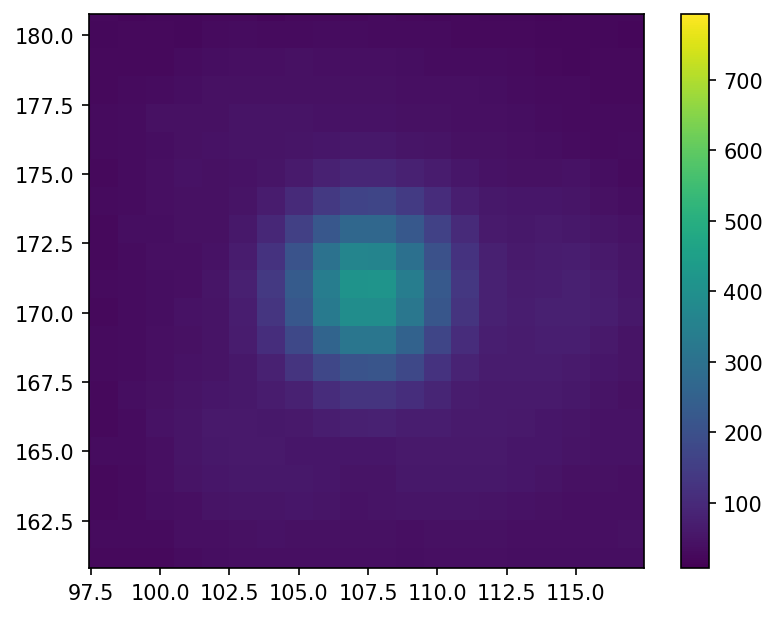

In [33]:
plot_individual_sources(d_cut, s_cut.iloc[:10], norm='linear')

In [43]:
np.min(d_cut)

6.654556

In [34]:
dataZ = d_cut - np.median(d_cut)

In [35]:
np.shape(dataZ)

(500, 500)

In [44]:
image_obs = PixelImage(*np.shape(dataZ))
image_obs.Z = dataZ
image_obs.Zerr = np.sqrt(d_cut)

In [45]:
N_sources = 5

In [46]:
xcenters, ycenters = np.array(s_cut[['xcentroid', 'ycentroid']])[:N_sources].T
source_half_extent = 10

## image mask

In [47]:
image_obs.define_mask(xcenters, ycenters, source_half_extent)

## initial guess for positions and fluxes

In [48]:
fap, xap, yap = image_obs.aperture_photometry(xcenters, ycenters, source_half_extent)
image_obs.lnfinit = np.log(np.array(fap))
image_obs.xinit = xap
image_obs.yinit = yap

In [49]:
'''
image_obs.idx_anchor = choose_anchor(image_obs, xcenters, ycenters, lnfluxes=np.log(fluxes), 
                                     plot=True, mad_threshold=10)
'''
idx_anchor = 0
image_obs.idx_anchor = idx_anchor

### make sure that the anchor is an isolated source and is not around the edge

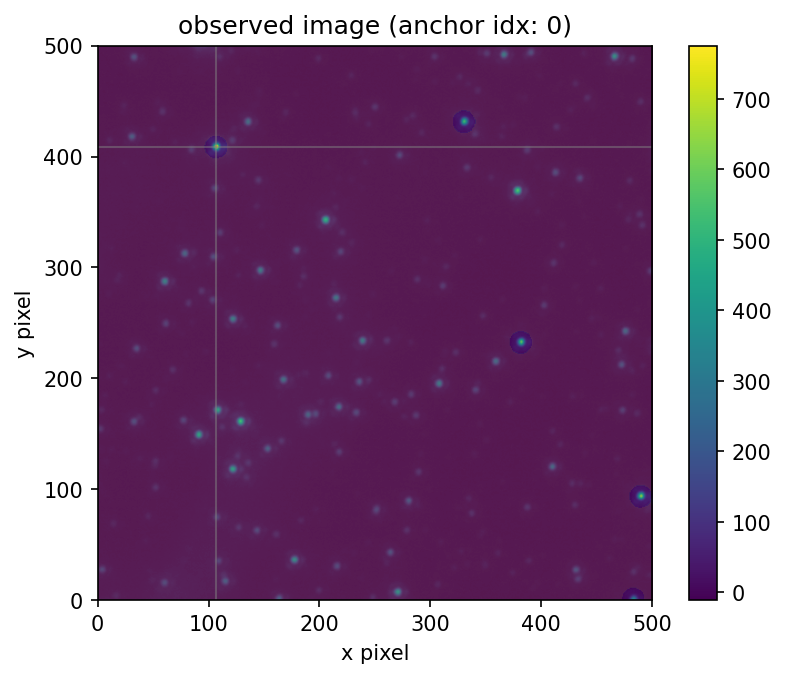

In [51]:
check_anchor(image_obs)

## define grid PSF model

In [52]:
psf_full_extent = source_half_extent * 2
dx, dy = 1./2., 1./2.
gridpsf = GridePSFModel(psf_full_extent, psf_full_extent, dx, dy)

PSF grid shape: (41, 41)
grid edge: x=[-10.250000, 10.250000], y=[-10.250000, 10.250000]
grid center: x=0.000000, y=0.000000


## optimization

In [53]:
%%time
res = optimize(gridpsf, image_obs, xyclim=[-source_half_extent, source_half_extent])
popt, state = res
popt = drop_anchor(popt, image_obs.idx_anchor)

# optimizing flux and position...


KeyboardInterrupt: 

In [409]:
mask1d = image_obs.mask1d
epsf1d_pred, _image1d_pred = gridpsf.predict_mean(popt['fluxes'], popt['xcenters'], popt['ycenters'], 
                            jnp.exp(popt['lnlenx']), jnp.exp(popt['lnleny']), jnp.exp(2*popt['lnamp']), jnp.exp(popt['lnmu']),
                            image_obs.X1d[~mask1d], image_obs.Y1d[~mask1d], image_obs.Z1d[~mask1d], image_obs.Zerr1d[~mask1d])
image1d_pred = np.zeros(image_obs.size)
image1d_pred[~mask1d] = _image1d_pred

In [410]:
ds = 0.5
x_offset = image_obs.xinit[image_obs.idx_anchor] - xcenters[image_obs.idx_anchor]
y_offset = image_obs.yinit[image_obs.idx_anchor] - ycenters[image_obs.idx_anchor]
finegrid = GridePSFModel(psf_full_extent, psf_full_extent, dx=ds, dy=ds)
epsf_pred = gridpsf.evaluate_ePSF(finegrid.X, finegrid.Y, x_offset, y_offset, epsf1d_pred)
#true_epsf = compute_epsf(finegrid, truepsffunc, dict(**{"norm": 1., "xc": 0, "yc": 0}, **truepsfkws))

PSF grid shape: (29, 29)
grid edge: x=[-7.250000, 7.250000], y=[-7.250000, 7.250000]
grid center: x=0.000000, y=0.000000


In [411]:
np.shape(epsf_pred)

(29, 29)

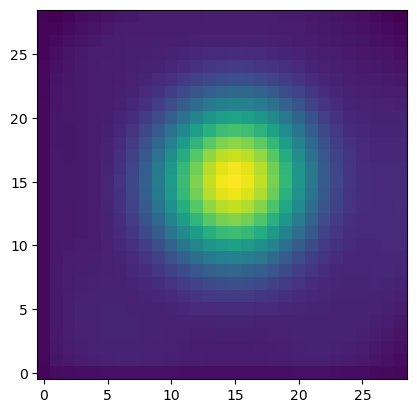

In [419]:
plt.imshow(epsf_pred, origin='lower')

In [413]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def check_image_fit(image_obs, image_pred):
    """ compare observed image and inferred true image """
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    mask, mask1d = image_obs.mask, image_obs.mask1d
    residual_image = image_obs.Z - image_pred.reshape(*image_obs.shape)
    residual_image = np.where(mask, 0., residual_image)
    im = ax[0].imshow(residual_image,
                      origin='lower',
                      extent=[
                          image_obs.xgrid_edge[0], image_obs.xgrid_edge[-1],
                          image_obs.ygrid_edge[0], image_obs.ygrid_edge[-1]
                      ])
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax)
    #ax[0].imshow(image_obs.mask, alpha=0.1)
    ax[0].set_title('data minus mean prediction')
    ax[0].set_xlim(image_obs.xgrid_edge[0], image_obs.xgrid_edge[-1])
    ax[0].set_ylim(image_obs.ygrid_edge[0], image_obs.ygrid_edge[-1])
    residual1d = np.array(image_obs.Z1d - image_pred) / image_obs.Zerr1d
    ax[1].hist(residual1d[~mask1d],
               histtype='step',
               lw=1,
               bins=30,
               density=True)
    ylim = ax[1].get_ylim()
    ax[1].set_yscale("log")
    ax[1].set_xlim(-5, 5)
    ax[1].set_ylim(None, ylim[1] * 1.2)
    x0 = np.linspace(-5, 5, 100)
    ax[1].plot(x0,
               np.exp(-0.5 * x0**2) / np.sqrt(2 * np.pi),
               color='gray',
               lw=1)
    ax[1].set_xlabel("residual normalized by error")

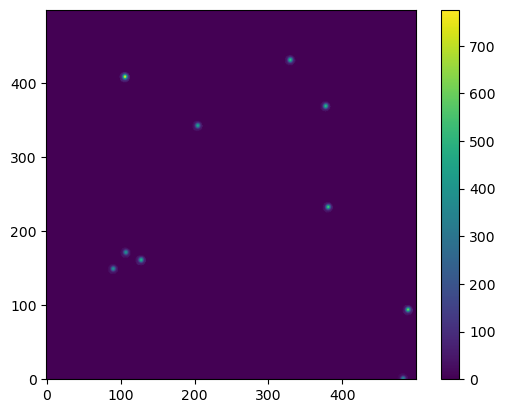

In [416]:
img = np.where(image_obs.mask, 0, image_obs.Z)
plt.imshow(img, origin='lower')
plt.colorbar()

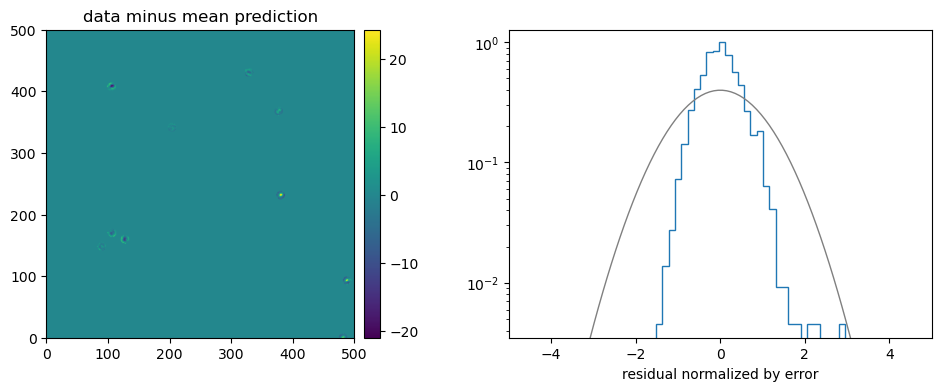

In [417]:
check_image_fit(image_obs, image1d_pred)

## run HMC

In [19]:
mcmc = run_hmc(gridpsf, image_obs, popt)

  0%|                                                                                                              | 0/1000 [00:00<?, ?it/s]/home/masuda/anaconda3/lib/python3.9/site-packages/jax/_src/tree_util.py:200: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
sample: 100%|████████████████████████████████████████████████| 1000/1000 [01:36<00:00, 10.34it/s, 15 steps of size 3.08e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      f[0]      1.27      0.01      1.27      1.26      1.28    790.66      1.00
      f[1]      3.73      0.01      3.73      3.71      3.74    589.55      1.00
      f[2]      2.85      0.01      2.85      2.84      2.87    620.99      1.00
      f[3]      2.42      0.01      2.42      2.41      2.43    647.12      1.00
      f[4]      1.87      0.01      1.87      1.86      1.89    641.56      1.00
      f[5]      4.65      0.01      4.65      4.63      4.67    653.27      1.00
      f[6]      2.48      0.01      2.48      2.46      2.49    633.26      1.00
      f[7]      1.89      0.01      1.89      1.88      1.91    747.38      1.00
      f[8]      6.01      0.01      6.01      5.99      6.03    446.87      1.00
       lna     -3.74      0.15     -3.74     -3.96     -3.49    445.78      1.00
    lnlenx      0.38      0.04      0.38      0.30      0.45    464.44      1.00
    lnleny      0.39      0

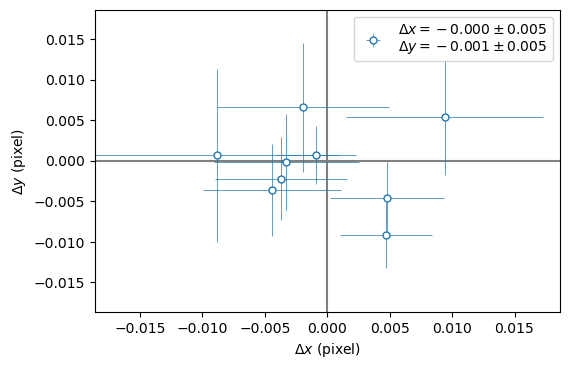

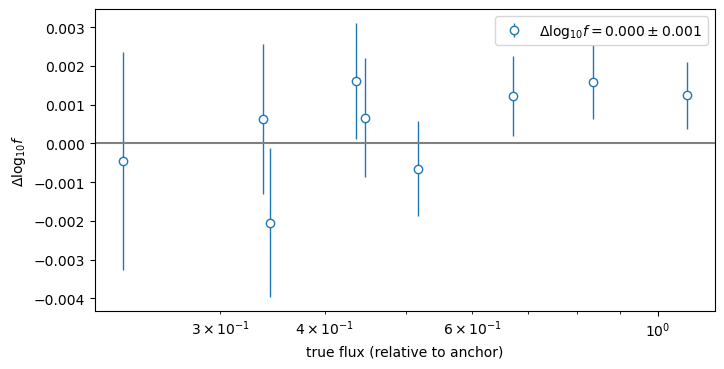

In [20]:
check_solution(image_obs, xcenters, ycenters, fluxes, samples=mcmc.get_samples())

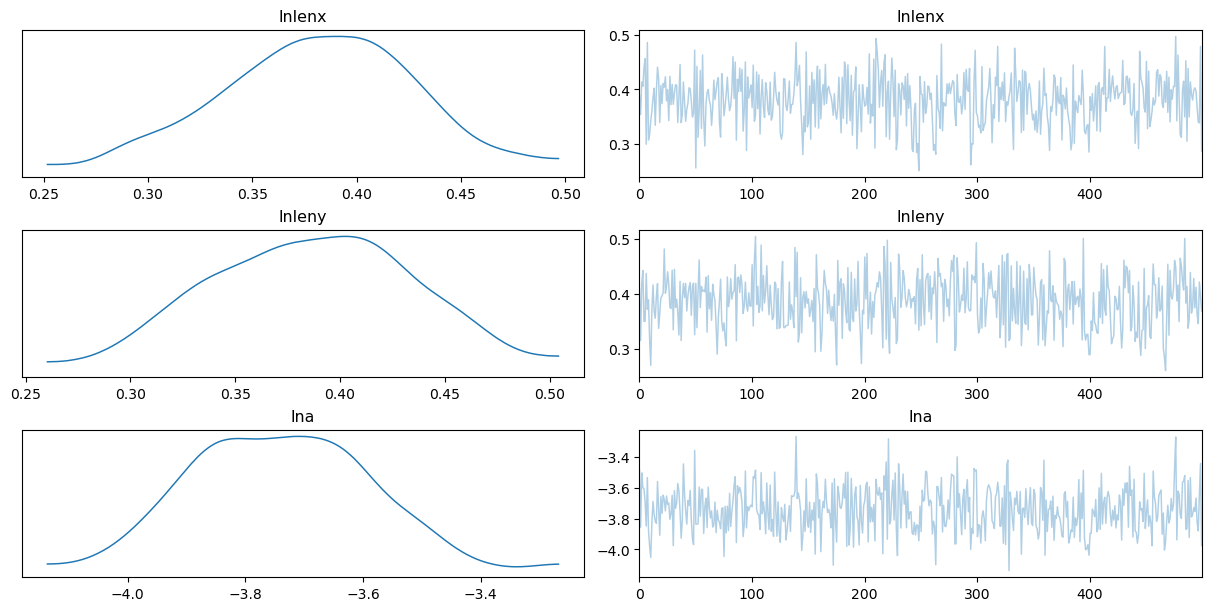

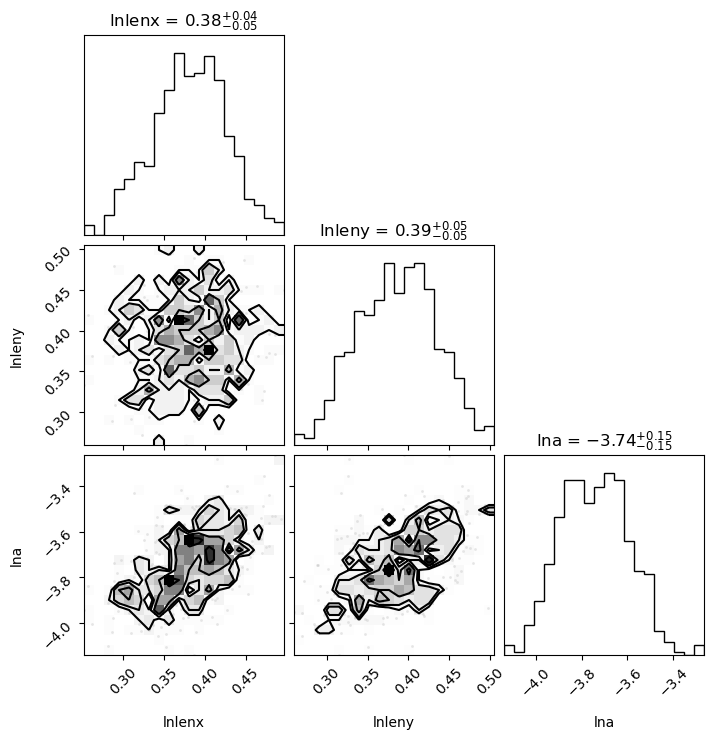

In [21]:
check_mcmc_hyperparameters(mcmc)